The purpose of this notebook is correcting ME webcrawl dataset so that it is more comparable with the other languages.

# Importing the dataset

In [1]:
import os
import gc
import parse
import logging
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 60)
from utils import (get_N_tokens, read_and_split_file, 
                    raw_dir, interim_dir, final_dir, 
                    load_SET_dataset, LABELS)

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)


In [4]:
texts, labels = list(), list()

files = ["bswac_tail_pp", "cnrwac_tail_pp", "hrwac_tail_pp", "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})

def count_words(instance: str) -> int:
    return len(instance.split(" "))
train["wc"] = train.text.apply(count_words)

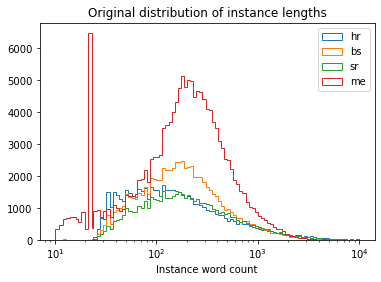

In [5]:
for l in LABELS:
    subset = train.loc[train.labels == l, :]
    plt.hist(subset.wc, label=l, histtype="step", 
            bins=np.logspace(1, 4, num=100, dtype=int))
plt.legend()
plt.semilogx()
plt.title("Original distribution of instance lengths")
plt.xlabel("Instance word count")
plt.savefig("images/19_original_word_count_distribution.png")
plt.show()

## Joining the orphaned instances

In [24]:
texts, labels = list(), list()

files = ["cnrwac_tail_pp"]

langs = ["me"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

medf = pd.DataFrame(data={"text": texts, "labels": labels})
print("Original size: ", medf.shape[0], "instances.")
print("Remove",medf.text.str.contains("   pogledano   puta   put promjenjen ").sum(), " instances.")
medf = medf.loc[~medf.text.str.contains("   pogledano   puta   put promjenjen "),:].reset_index(drop=True)
def count_words(instance: str) -> int:
    return len(instance.split(" "))
medf["wc"] = medf.text.apply(count_words)


c = medf.wc < 20

indices_to_correct = medf.loc[c, :].index.values
for i in indices_to_correct:
    try:
        row = medf.iloc[i, :]
        short_text = row.text
        neighbour_text = medf.iloc[i+1, :].text
        medf.iloc[i+1, 0] = neighbour_text + " " + short_text
    except IndexError:
        row = medf.iloc[i, :]
        short_text = row.text
        neighbour_text = medf.iloc[0, :].text
        medf.iloc[0, 0] = neighbour_text + " " + short_text

medf.drop(indices_to_correct, inplace=True)
medf["wc"] = medf.text.apply(count_words)
print(f"Number of instances after corrections: {medf.shape[0]}")

Original size:  152852 instances.
Remove 5928  instances.
Number of instances after corrections: 140737


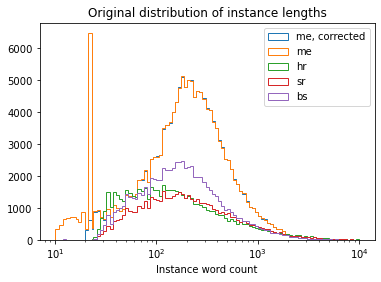

In [19]:
plt.hist(medf.wc, histtype="step", 
            bins=np.logspace(1, 4, num=100, dtype=int),
            label="me, corrected")
for l in ["me", "hr", "sr", "bs"]:
    subset = train.loc[train.labels == l, :]
    plt.hist(subset.wc, label=l, histtype="step", 
            bins=np.logspace(1, 4, num=100, dtype=int))
plt.legend()
plt.semilogx()
plt.title("Original distribution of instance lengths")
plt.xlabel("Instance word count")
plt.savefig("images/19_word_count_distribution_comparison_2.png")
plt.show()


In [21]:
target_file = os.path.join(interim_dir, "cnrwac_tail_pp_corrected_2")
content = "\n\n".join(medf.text.tolist())

In [22]:
with open(target_file, "w") as f:
    f.write(content)

In [23]:
medf.shape

(140737, 3)